Import/start


In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount='True')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import math
import copy
import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('/content/drive/MyDrive/dataset_mood_smartphone.csv')  

df = df.drop(['Unnamed: 0'], axis=1)
df2 = copy.deepcopy(df)
df3 = copy.deepcopy(df)

Mounted at /content/drive


In [9]:
def get_date_list(indeces, window_size):
  big_list = []
  indeces = pd.to_datetime(indeces)
  for i, date in enumerate(indeces):
    l = []
    date1 = date
    for j, date2 in enumerate(indeces[i:]):
      if len(l)>window_size:
        big_list.append(l)
        break

      if pd.Timedelta(date2-date1).days > 1:
        break

      else:
        l.append(date2.date())
        date1 = date2

  return big_list



In [10]:
df['time'] = pd.to_datetime(df['time'])
df['night'] = (df.time.dt.hour >= 1) & (df.time.dt.hour < 10)
df['night'].replace({False: 0, True: 1}, inplace=True)

df

,id,time,variable,value,night
0,AS14.01,2014-02-26 13:00:00.000,mood,6.000,0
1,AS14.01,2014-02-26 15:00:00.000,mood,6.000,0
2,AS14.01,2014-02-26 18:00:00.000,mood,6.000,0
3,AS14.01,2014-02-26 21:00:00.000,mood,7.000,0
4,AS14.01,2014-02-27 09:00:00.000,mood,6.000,1
...,...,...,...,...,...
376907,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032,1
376908,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008,0
376909,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026,0
376910,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033,0


make df


In [11]:
df['time']= pd.to_datetime(df['time']).dt.date
df.min(axis=0)
df.id.unique()
# df = df.loc[df['screen'] > 1]
df = df.pivot_table(index=['id', 'time'], columns='variable', values='value', aggfunc=np.sum)

df2 = deepcopy of df -> to make mean mood

In [12]:
df2['time']= pd.to_datetime(df2['time']).dt.date

df2.min(axis=0)
df2.id.unique()
# df = df.loc[df['screen'] > 1]
df2 = df2.pivot_table(index=['id', 'time'], columns='variable', values='value', aggfunc=np.mean)

add av_mood to df


In [13]:
df['av_mood'] = df2['mood']
df['circumplex.arousal'] = df2['circumplex.arousal']
df['circumplex.valence'] = df2['circumplex.valence']
df.dropna(subset=['mood'], inplace=True)
df.fillna(0, inplace=True)

In [14]:
df.reset_index(level='id', drop=False, inplace=True)


df.index = pd.to_datetime(df.index)
# colls = ['activity', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'call', 'circumplex.arousal', 'circumplex.valence', 'av_mood', 'screen', 'sms']
colls = ['activity', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'call', 'circumplex.arousal', 'circumplex.valence', 'av_mood', 'screen', 'sms']

# colls = ['activity','call', 'circumplex.arousal', 'circumplex.valence', 'mood', 'screen', 'sms']
# colls = ['activity','call', 'circumplex.arousal', 'circumplex.valence', 'av_mood', 'screen', 'sms']

df = df.groupby('id')[colls].rolling('6D', min_periods=5, closed='both').mean()
df['mood_train'] = df['av_mood']
df['av_mood'] = df2['mood']

colls.append('mood_train')
colls.remove('av_mood')


In [15]:
MLP_df = df
MLP_df['av_mood'] = MLP_df.groupby('id')['av_mood'].shift(-1)
MLP_df['circumplex.arousal'] += 4
MLP_df['circumplex.valence'] += 4
MLP_df = df.reset_index(drop=True).dropna()
MLP_df.head(50)

variable,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,call,circumplex.arousal,circumplex.valence,av_mood,screen,sms,mood_train
6,2.654079,1411.323400,7205.701400,448.060600,131.218800,2198.413600,274.511000,4.704460e+01,2.296172e+02,3.800000,4.460000,4.400000,6.60,13483.521200,0.400000,6.430000
7,2.616966,1370.685667,7502.876667,525.130333,125.598667,2597.354500,228.759167,3.920383e+01,1.969085e+02,3.166667,4.350000,4.433333,7.00,13973.567834,0.333333,6.458333
8,2.744433,1350.491571,7421.967429,541.445857,116.017714,2359.929714,202.838429,3.360329e+01,1.943543e+02,3.000000,4.328571,4.485714,6.40,14469.079571,0.428571,6.535714
9,2.632090,2339.545429,6648.530714,541.152571,114.046286,1789.107000,233.919000,3.360329e+01,1.519204e+02,2.857143,4.214286,4.542857,8.00,12604.019857,0.428571,6.564286
10,2.324488,2514.002714,6328.212714,760.310429,124.253571,1793.857857,236.080429,3.360329e+01,2.209227e+02,3.000000,4.157143,4.614286,7.50,12915.514286,0.428571,6.792857
11,2.116800,2389.448286,5765.525000,966.214857,124.422143,1689.121571,236.080429,4.310000e+01,2.220956e+02,3.000000,4.057143,4.607143,7.40,12593.997429,0.428571,6.892857
12,2.087809,2688.655286,5202.954714,1077.921857,153.278714,1421.554286,202.305571,4.728429e+01,2.266060e+02,2.428571,3.942857,4.692857,6.00,12135.352143,0.428571,7.092857
13,2.156618,2739.048000,4605.636857,1215.412000,145.046000,1867.353714,432.965714,1.368100e+01,2.687121e+02,2.571429,3.900000,4.621429,6.50,11520.859429,0.285714,6.985714
14,2.158703,3088.598286,4310.123000,1277.254429,208.480714,1701.172714,432.965714,1.368100e+01,3.127130e+02,3.142857,3.976190,4.630952,6.40,12225.818000,0.285714,6.971429
15,1.826202,3244.617857,5381.775857,1370.724714,230.676429,2018.152714,428.932571,1.368100e+01,3.132477e+02,3.428571,3.776190,4.516667,6.20,12791.487286,0.142857,6.885714


In [16]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn import preprocessing


#Make array
X = np.array(MLP_df[colls])
y = np.array(MLP_df['av_mood'], dtype=float)

#normalise
# X_n = X-X.min(axis=0) / X.max(axis=0)-X.min(axis=0)
X_n = X/ X.mean(axis=0)
# y_n = y / y.max(axis=0)

# print(X_n.shape)

#LDA, reduce dimensions
# X_n = PCA(n_components=5).fit_transform(X_n)
# X_n_reduced = LDA_transform.transform(X_n)

# print(X_n.shape)
# Split
X_train, X_test, y_train, y_test = train_test_split(X_n, y,
                                                    random_state=1)


# regr = MLPRegressor(random_state=1, max_iter=500, hidden_layer_sizes=(512,1024, 4)).fit(X_train, y_train)
regr = RandomForestRegressor(n_estimators=500, random_state=0).fit(X_train, y_train)
# regr = LinearSVR().fit(X_train, y_train)
# regr = LinearRegression().fit(X_train, y_train)
# regr = KNeighborsRegressor(n_neighbors=10).fit(X_train, y_train)


# print(regr.predict(X_test[:20]), y_test[:20])

test_pred = regr.predict(X_test)


print('MSE Loss = ' , ((test_pred - y_test)**2).mean())

regr.score(X_test, y_test)




MSE Loss =  0.3837717119296168


0.20734301709786895

In [17]:
sorted([i for i in zip(regr.feature_importances_,[i for i in colls])],key= lambda x: x[0],reverse=True)


[(0.35896741377315605, 'mood_train'),
 (0.06286458760347263, 'appCat.social'),
 (0.06220695417229826, 'circumplex.arousal'),
 (0.059740757280305944, 'circumplex.valence'),
 (0.05448294510328983, 'sms'),
 (0.05214104255897917, 'appCat.communication'),
 (0.04976093737474665, 'appCat.entertainment'),
 (0.04784306484856196, 'appCat.builtin'),
 (0.046845668961016614, 'call'),
 (0.04475633634667199, 'appCat.other'),
 (0.041933041509194045, 'activity'),
 (0.03482261289051724, 'appCat.travel'),
 (0.03403009352847599, 'screen'),
 (0.025051581720208757, 'appCat.unknown'),
 (0.024552962329104786, 'appCat.utilities')]

In [18]:
u_b = ((y_test - np.roll(y_test,-1)) ** 2).sum()
v_b = ((y_test - y_test.mean()) ** 2).sum()


print('Baseline Score = ',(1- (u_b/v_b)))
print('Baseline MSE = ',  ((np.roll(y_test,-1) - y_test)**2).mean())


Baseline Score =  -0.8806028503066439
Baseline MSE =  0.9105100830367733


line plots: mood vs time for every person

{'AS14.24', 'AS14.23', 'AS14.09', 'AS14.05', 'AS14.08', 'AS14.02', 'AS14.27', 'AS14.07', 'AS14.03', 'AS14.20', 'AS14.12', 'AS14.26', 'AS14.31', 'AS14.33', 'AS14.19', 'AS14.28', 'AS14.06', 'AS14.29', 'AS14.30', 'AS14.13', 'AS14.25', 'AS14.14', 'AS14.15', 'AS14.17', 'AS14.01', 'AS14.16', 'AS14.32'}
AS14.24


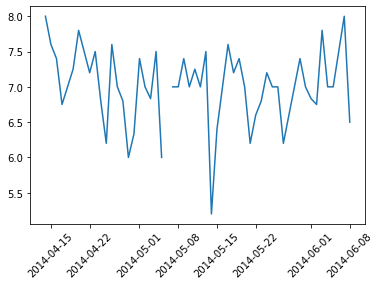

AS14.23


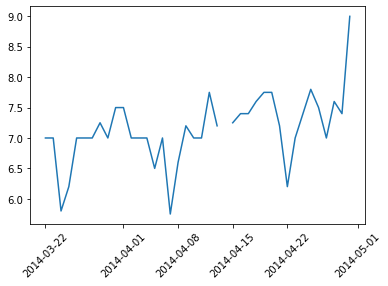

AS14.09


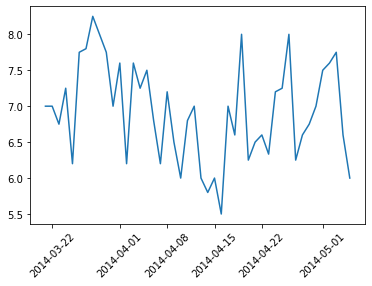

AS14.05


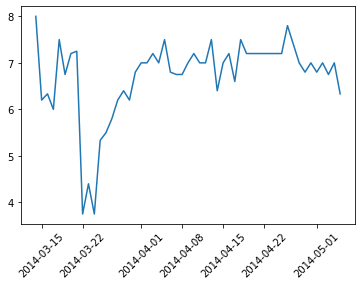

AS14.08


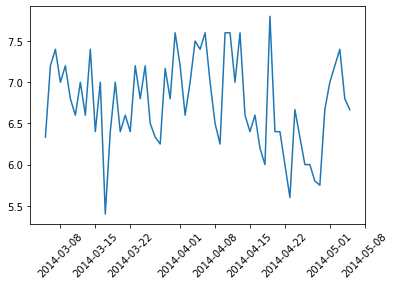

AS14.02


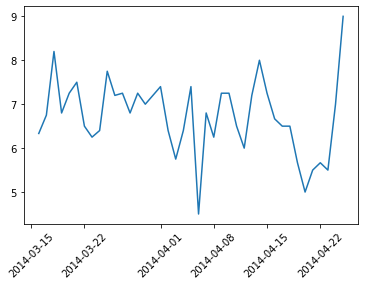

AS14.27


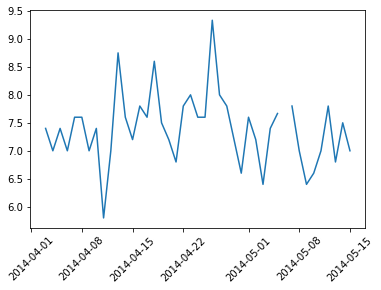

AS14.07


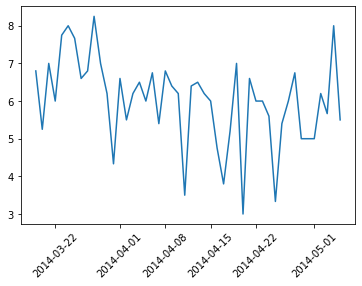

AS14.03


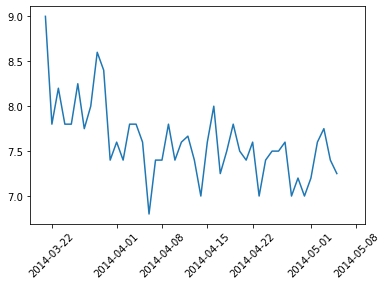

AS14.20


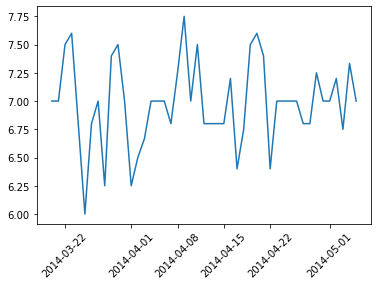

AS14.12


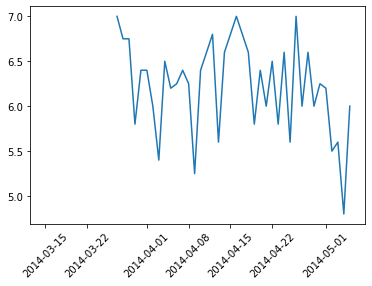

AS14.26


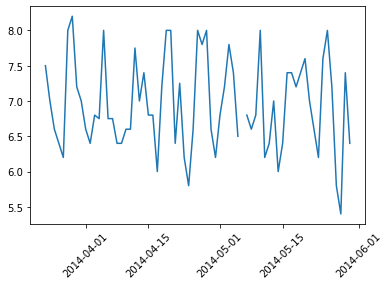

AS14.31


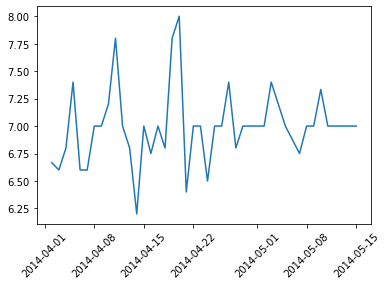

AS14.33


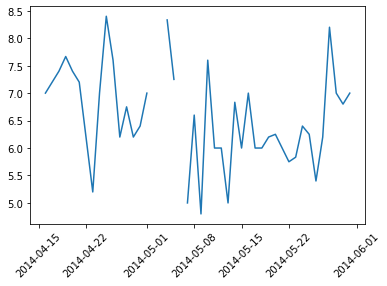

AS14.19


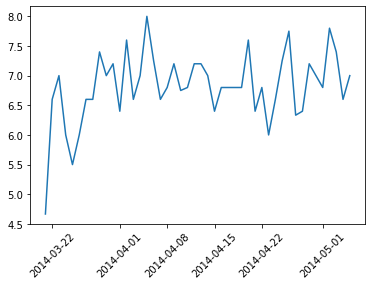

AS14.28


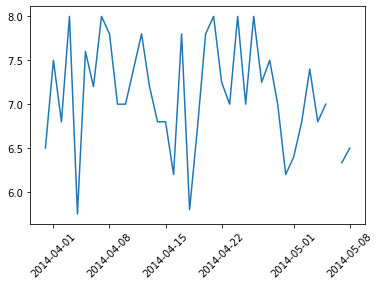

AS14.06


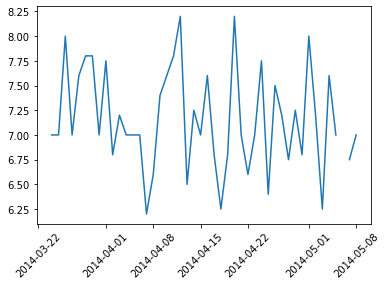

AS14.29


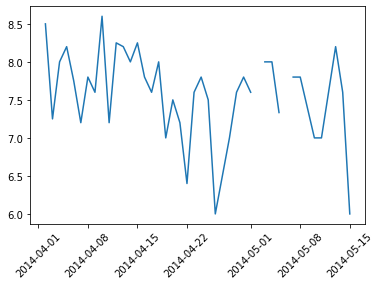

AS14.30


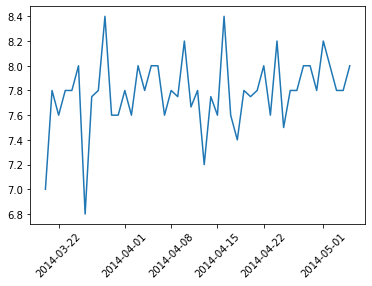

AS14.13


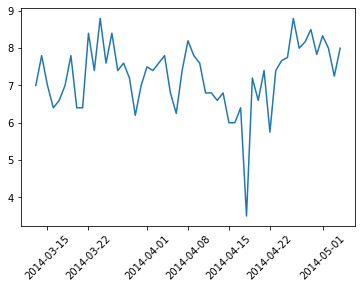

AS14.25


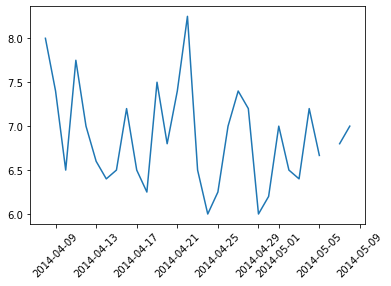

AS14.14


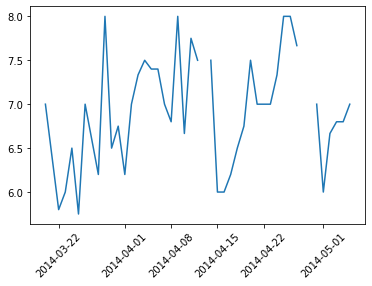

AS14.15


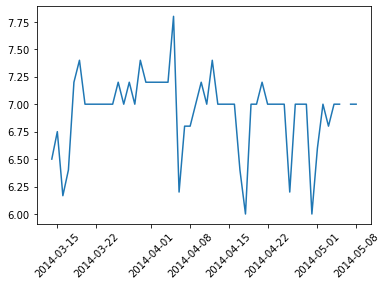

AS14.17


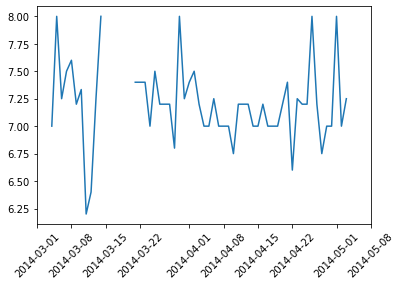

AS14.01


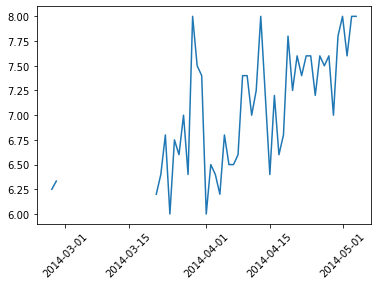

AS14.16


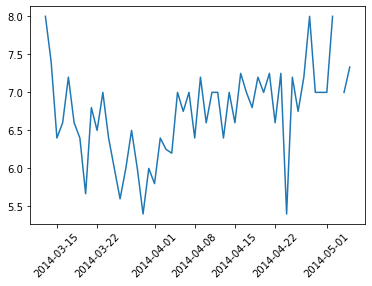

AS14.32


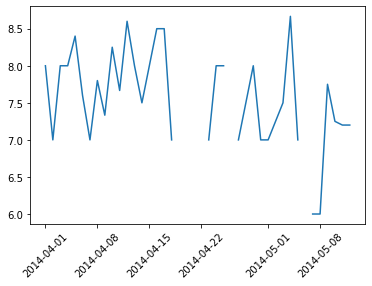

variable            activity  appCat.builtin  ...       sms  mood_train
id      time                                  ...                      
AS14.01 2014-02-26       NaN             NaN  ...       NaN         NaN
        2014-02-27       NaN             NaN  ...       NaN         NaN
        2014-03-21       NaN             NaN  ...       NaN         NaN
        2014-03-22       NaN             NaN  ...       NaN         NaN
        2014-03-23       NaN             NaN  ...       NaN         NaN
...                      ...             ...  ...       ...         ...
AS14.03 2014-03-28  2.490693      442.272286  ...  0.571429    7.942857
        2014-03-29  2.695408      376.161143  ...  0.571429    8.057143
        2014-03-30  2.892701      307.631571  ...  0.428571    8.085714
        2014-03-31  2.868335      586.595857  ...  0.571429    8.028571
        2014-04-01  2.747122      515.048429  ...  0.428571    8.000000

[100 rows x 16 columns]

In [21]:

id_set = set()
for indexnumber in df2.index:
  id_set.add(indexnumber[0])
print(id_set)
for id in id_set:
  print(id)
  x =[]
  y = []
  for indexnumber in df2.index:
    if indexnumber[0] == id:
      x.append(indexnumber[1])
      y.append(df2.loc[indexnumber,'mood'])

  plt.plot(x, y)
  plt.xticks(rotation=45)
  plt.show()  
df.head(100)

nan to 0 


In [ ]:
# df = df.drop(df.loc[df['mood'].isna()], axis=1)
print(df.shape)
df = df[df['mood'].notna()]
print(df.shape)
# df.fillna(0, inplace=True)
df.head(100)
print(df.isna().sum()/1268)
# print(df.notna().sum())

# plt.matshow(df.corr(axis=1))
# plt.show()

(1268, 16)


KeyError: ignored

correlation matrix


In [ ]:
cols = ['activity', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'call', 'circumplex.arousal', 'circumplex.valence', 'mood', 'screen', 'sms']
corrmat = df[cols].corr()
sns.heatmap(corrmat, square=True, annot=True)
sns.clustermap(corrmat, square=True, annot=False)

make boxplots

Index(['activity', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'call',
       'circumplex.arousal', 'circumplex.valence', 'mood', 'screen', 'sms'],
      dtype='object', name='variable')


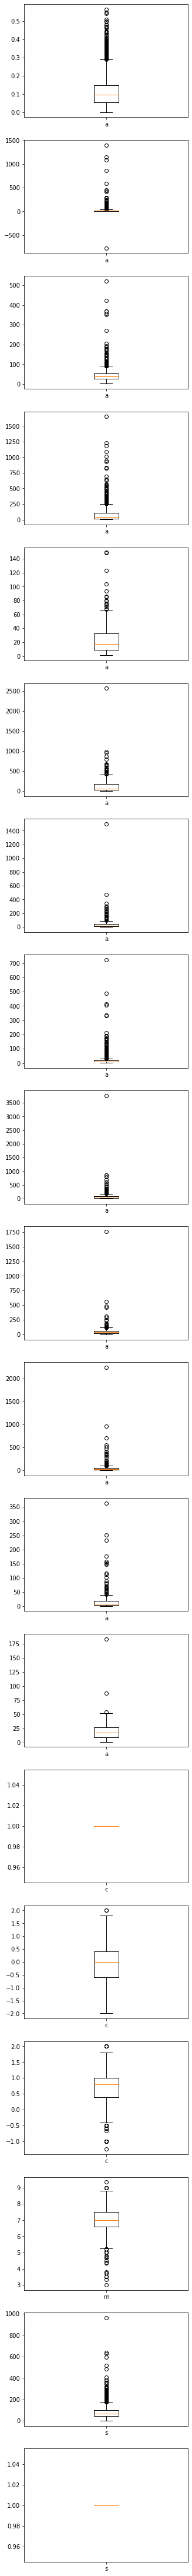

In [ ]:
print(df2.columns)
fig, ax = plt.subplots(len(df2.columns), figsize=(5,80))
for i in range(len(df2.columns)):
  data = df2[df2.columns[i]]
  data_no_nan = data.dropna()
  # print(data_no_nan)
  # for j in range(len(data_no_nan)):
  #   if pd.isna(data_no_nan[j]):
  #     print(data_no_nan[j])
  ax[i].set_xticklabels(df2.columns[i])
  ax[i].boxplot(data_no_nan)
  

make qqplot


In [ ]:
for i in range(len(df.columns)):
  data = df[df.columns[i]]
  data_no_nan = data.dropna()
  fig = sm.qqplot(data_no_nan)
  plt.show()
  print(df.columns[i])


In [ ]:
# df1 = df.id
df_user_1 = df.loc[df['id'] == 'AS14.01']
df_user_1 = df_user_1.drop(['id'], axis=1)
# df_user_1 = df_user_1.set_index('time')

# # df_user_1.groupby(df.variable).head()
# df_user_1.groupby(['time', 'variable']).mean().reset_index()

df_user_1 = df_user_1.pivot_table(index='time', columns='variable', values='value', aggfunc='sum')

df_user_1.head(100)


# values = df_user_1.values
# # specify columns to plot
# groups = [0, 1, 2, 3, 5, 6, 7]
# i = 1
# # plot each column
# plt.figure()
# for group in groups:
# 	plt.subplot(len(groups), 1, i)
# 	plt.plot(values[:, group])
# 	plt.title(df_user_1.columns[group], y=0.5, loc='right')
# 	i += 1
# plt.show()

In [ ]:
len(df.variable.unique())

In [ ]:
df2 = df.set_index('id')
df2.head()

In [ ]:
df.groupby(df.id).head()

# df.groupby(df.variable).head()

# df.groupby(df.time.dt.date).head()